### Imports and Setup

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
import numpy as np
import cv2
import os
import glob
import random
import gc
# ADDED precision_score and recall_score HERE:
from sklearn.metrics import (
    roc_auc_score, 
    precision_recall_curve, 
    accuracy_score, 
    f1_score, 
    precision_score, 
    recall_score
)
import matplotlib.pyplot as plt

# Hardware setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)
print(f"System Ready. Computing on: {device}")

System Ready. Computing on: cuda


### Experimental Configuration

In [2]:
TARGET_CATEGORIES = ['leather', 'metal_nut', 'bottle', 'zipper']

HYPERPARAMS = {
    'img_size': 320,      # Back to the optimal resolution
    'batch_size': 16,
    'num_epochs': 100,     # The "Goldilocks" duration
    'lr': 1e-3,
    'weight_decay': 1e-5,
    'milestones': [80],   # Step-down at epoch 80
    'gamma': 0.1,
    'seed': 42
}

### Dataset Pipeline

In [3]:
class MVTecDataset(Dataset):
    """
    Custom Dataset class for loading MVTec-AD data.
    Handles dynamic path resolution and ImageNet normalization.
    """
    def __init__(self, category, split='train', img_size=320):
        self.img_size = img_size
        self.use_mask = (split == 'test')
        self.images = []
        self.masks = []
        
        # 1. Locate the dataset directory dynamically
        # This makes the code robust to different folder structures on Kaggle
        search_pattern = f"/kaggle/input/**/{category}"
        candidates = glob.glob(search_pattern, recursive=True)
        
        if not candidates:
            raise ValueError(f"Dataset for category '{category}' not found.")
            
        root_path = candidates[0]
        
        # 2. Load Image Paths
        if split == 'train':
            # Training only uses 'good' (nominal) images for unsupervised learning
            self.images = glob.glob(os.path.join(root_path, 'train', 'good', '*.png'))
        else:
            # Testing uses both 'good' and 'defective' images
            self.images = glob.glob(os.path.join(root_path, 'test', '*', '*.png'))
            
        self.images.sort()
        
        # 3. Load Ground Truth Masks (For pixel-level evaluation)
        if self.use_mask:
            for img_path in self.images:
                parts = img_path.split(os.sep)
                defect_type = parts[-2]
                filename = parts[-1]
                
                if defect_type == 'good':
                    self.masks.append(None) # Nominal images have no mask
                else:
                    # Construct path to the corresponding binary mask
                    mask_name = filename.replace('.png', '_mask.png')
                    mask_path = os.path.join(root_path, 'ground_truth', defect_type, mask_name)
                    self.masks.append(mask_path)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Read and convert image to RGB
        img_path = self.images[idx]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Standard ImageNet normalization 
        # (Required because we use pre-trained backbones)
        transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((self.img_size, self.img_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                 std=[0.229, 0.224, 0.225])
        ])
        
        img_t = transform(img)
        
        # Handle Masks for Testing
        if not self.use_mask:
            return img_t, torch.zeros(1), 0
            
        mask_path = self.masks[idx]
        if mask_path is None:
            # Create a black mask for good images
            mask = torch.zeros((1, self.img_size, self.img_size))
            label = 0
        else:
            # Load the actual ground truth mask
            mask_img = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            mask_img = cv2.resize(mask_img, (self.img_size, self.img_size))
            mask = torch.from_numpy(mask_img / 255.0).float().unsqueeze(0)
            label = 1 # Flag as anomaly
            
        return img_t, mask, label

### Feature Extractor Network

In [4]:
class FeatureExtractor(nn.Module):
    """
    Wraps a ResNet backbone to return features from three intermediate layers.
    Including Layer 1 provides the 'micro-detail' needed for small structural defects.
    """
    def __init__(self, backbone_name):
        super(FeatureExtractor, self).__init__()
        
        if backbone_name == 'wide_resnet50_2':
            self.backbone = models.wide_resnet50_2(weights=models.Wide_ResNet50_2_Weights.DEFAULT)
        else:
            self.backbone = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
            
        self.layer1_seq = nn.Sequential(
            self.backbone.conv1, self.backbone.bn1, 
            self.backbone.relu, self.backbone.maxpool, 
            self.backbone.layer1
        )
        self.layer2 = self.backbone.layer2
        self.layer3 = self.backbone.layer3

    def forward(self, x):
        l1 = self.layer1_seq(x) # Micro-scale (high res)
        l2 = self.layer2(l1)    # Mid-scale (textures)
        l3 = self.layer3(l2)    # Global-scale (structure)
        return [l1, l2, l3]     # Return 3 layers instead of 2

### Linear Adapter

In [ ]:
class Adapter(nn.Module):
    """
    Standard Linear Adapter.
    Uses a simple 1x1 convolution to project Student features 
    into the Teacher's dimensional space.
    """
    def __init__(self, in_channels, out_channels):
        super(Adapter, self).__init__()
        self.layer = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        
    def forward(self, x):
        return self.layer(x)

### Training Logic

In [6]:
def train_epoch(teacher, student, adapter2, adapter3, optimizer, loader):
    # Set modes: Student trains, Teacher stays frozen (eval)
    student.train()
    adapter2.train()
    adapter3.train()
    teacher.eval()
    
    running_loss = 0.0
    
    for images, _, _ in loader:
        images = images.to(device)
        
        # 1. Forward Pass - Teacher
        # No gradient calculation needed for Teacher
        with torch.no_grad():
            teacher_features = teacher(images)
            
        # 2. Forward Pass - Student
        student_features = student(images)
        
        # 3. Adaptation
        # Project Student features to match Teacher dimensions
        s_feat_2 = adapter2(student_features[0])
        s_feat_3 = adapter3(student_features[1])
        
        # 4. Calculate Loss
        # We calculate MSE Loss at both Layer 2 and Layer 3
        loss_l2 = F.mse_loss(s_feat_2, teacher_features[0])
        loss_l3 = F.mse_loss(s_feat_3, teacher_features[1])
        loss = loss_l2 + loss_l3
        
        # 5. Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    return running_loss / len(loader)

### Inference & Scoring

In [ ]:
def normalize_map(m):
    return (m - m.mean()) / (m.std() + 1e-6)

def evaluate(teacher, student, adapter1, adapter2, adapter3, loader, category):
    teacher.eval()
    student.eval()
    adapter1.eval()
    adapter2.eval()
    adapter3.eval()

    labels_list, scores_list = [], []

    for images, _, labels in loader:
        images = images.to(device)

        with torch.no_grad():
            t_out = teacher(images)
            s_out = student(images)

            s1 = adapter1(s_out[0])
            s2 = adapter2(s_out[1])
            s3 = adapter3(s_out[2])

            h, w = t_out[0].shape[-2:]

            diff_l1 = torch.sum((t_out[0] - s1) ** 2, 1, keepdim=True)
            diff_l2 = F.interpolate(
                torch.sum((t_out[1] - s2) ** 2, 1, keepdim=True),
                size=(h, w), mode='bilinear', align_corners=False
            )
            diff_l3 = F.interpolate(
                torch.sum((t_out[2] - s3) ** 2, 1, keepdim=True),
                size=(h, w), mode='bilinear', align_corners=False
            )

            
            # Only ZIPPER gets normalization. 
            if category == 'zipper':
                combined = (
                    normalize_map(diff_l1) +
                    normalize_map(diff_l2) +
                    normalize_map(diff_l3)
                )
            else: 
                combined = diff_l1 + diff_l2 + diff_l3

            amap = F.interpolate(combined, size=(320, 320), mode='bilinear')
            amap = amap.squeeze().cpu().numpy()

            
            # CATEGORY-AWARE SMOOTHING
            if category == 'zipper':
                amap = cv2.GaussianBlur(amap, (7, 7), 1.5)
            else:
                amap = cv2.GaussianBlur(amap, (5, 5), 0)

            
            # CATEGORY-AWARE SCORING
            if category == 'metal_nut':
                # Top-100 average is best for rigid objects
                img_score = np.mean(np.sort(amap.flatten())[-100:])
            elif category == 'zipper':
                # Percentile catches the cluster of defect pixels
                img_score = np.percentile(amap, 99.5)
            else: 
                # Standard Max is best for simple textures (Leather/Bottle)
                img_score = np.max(amap)

            scores_list.append(img_score)
            labels_list.append(labels.item())

    return np.array(labels_list), np.array(scores_list)

### Main Experiment Loop

In [ ]:

results = {}

print("Starting FINAL OPTIMIZED Training (Normalization + Percentile Pooling)...")

for category in TARGET_CATEGORIES:
    print(f"\nProcessing Category: {category.upper()}")
    print("-" * 40)
    
    # 1. Data Setup
    # CRITICAL: 'split=train' only loads good images. 
    # This ensures the model learns the "Manifold of Normality" without seeing defects.
    train_loader = DataLoader(
        MVTecDataset(category, split='train'),
        batch_size=HYPERPARAMS['batch_size'],
        shuffle=True,
        num_workers=2
    )
    
    test_loader = DataLoader(
        MVTecDataset(category, split='test'),
        batch_size=1,
        shuffle=False
    )
    
    # 2. Model Initialization (Student-Teacher Pair)
    # Teacher: Frozen WideResNet-50 (The Oracle) 
    teacher = FeatureExtractor('wide_resnet50_2').to(device).eval()
    for p in teacher.parameters():
        p.requires_grad = False
    
    # Student: Trainable ResNet-18 (The Mimic)
    student = FeatureExtractor('resnet18').to(device).train()
    
    # 3. Multi-Scale Alignment
    # We initialize 3 linear adapters to bridge the channel gap at Layers 1, 2, and 3.
    adapter1 = Adapter(64, 256).to(device)   # Micro-scale
    adapter2 = Adapter(128, 512).to(device)  # Texture-scale
    adapter3 = Adapter(256, 1024).to(device) # Structural-scale
    
    optimizer = torch.optim.Adam(
        list(student.parameters()) +
        list(adapter1.parameters()) +
        list(adapter2.parameters()) +
        list(adapter3.parameters()),
        lr=HYPERPARAMS['lr'],
        weight_decay=HYPERPARAMS['weight_decay']
    )
    
    # Step-Decay Schedule: Fast convergence -> Fine-tuning
    scheduler = torch.optim.lr_scheduler.MultiStepLR(
        optimizer,
        milestones=HYPERPARAMS['milestones'],
        gamma=HYPERPARAMS['gamma']
    )
    
    # 4. Training Execution
    for epoch in range(HYPERPARAMS['num_epochs']):
        student.train()
        adapter1.train()
        adapter2.train()
        adapter3.train()
        
        total_loss = 0.0
        
        for images, _, _ in train_loader:
            images = images.to(device)
            
            with torch.no_grad():
                t_feats = teacher(images)
            
            s_feats = student(images)
            
            # Loss Calculation: Sum of MSE across the Feature Pyramid
            # Forces Student to match Teacher at Micro, Meso, and Macro scales
            # 
            loss = (
                F.mse_loss(adapter1(s_feats[0]), t_feats[0]) +
                F.mse_loss(adapter2(s_feats[1]), t_feats[1]) +
                F.mse_loss(adapter3(s_feats[2]), t_feats[2])
            )
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        scheduler.step()
        
        if (epoch + 1) % 10 == 0:
            print(f"  Epoch {epoch+1}/{HYPERPARAMS['num_epochs']} | Loss: {total_loss/len(train_loader):.6f}")
    
    # 5. Evaluation & Thresholding
    print("  Evaluating...")
    labels, scores = evaluate(
        teacher, student,
        adapter1, adapter2, adapter3,
        test_loader, category
    )
    
    auc = roc_auc_score(labels, scores)
    
    precision, recall, thresholds = precision_recall_curve(labels, scores)
    
    # Safety-Critical Optimization:
    # We weight Recall higher (0.7) to minimize missed defects (False Negatives).
    score = 0.7 * recall[:-1] + 0.3 * precision[:-1]
    best_thresh = thresholds[np.argmax(score)]
    
    print(f"  Result: AUROC = {auc:.4f}")
    
    results[category] = auc
    
    # Save Checkpoint (Including all 3 adapters)
    torch.save({
        'student': student.state_dict(),
        'adapter1': adapter1.state_dict(),
        'adapter2': adapter2.state_dict(),
        'adapter3': adapter3.state_dict(),
        'threshold': best_thresh,
        'auc': auc
    }, f"efficientad_{category}.pth")
    
    del teacher, student, adapter1, adapter2, adapter3, optimizer
    gc.collect()
    torch.cuda.empty_cache()

Starting FINAL OPTIMIZED Training (Normalization + Percentile Pooling)...

Processing Category: LEATHER
----------------------------------------
Downloading: "https://download.pytorch.org/models/wide_resnet50_2-9ba9bcbe.pth" to /root/.cache/torch/hub/checkpoints/wide_resnet50_2-9ba9bcbe.pth


100%|██████████| 263M/263M [00:05<00:00, 54.6MB/s] 


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 183MB/s] 


  Epoch 10/100 | Loss: 0.877576
  Epoch 20/100 | Loss: 0.633413
  Epoch 30/100 | Loss: 0.521086
  Epoch 40/100 | Loss: 0.462367
  Epoch 50/100 | Loss: 0.425371
  Epoch 60/100 | Loss: 0.398717
  Epoch 70/100 | Loss: 0.379904
  Epoch 80/100 | Loss: 0.365282
  Epoch 90/100 | Loss: 0.358155
  Epoch 100/100 | Loss: 0.356304
  Evaluating...
  Result: AUROC = 0.9952

Processing Category: METAL_NUT
----------------------------------------
  Epoch 10/100 | Loss: 1.312406
  Epoch 20/100 | Loss: 0.998315
  Epoch 30/100 | Loss: 0.864449
  Epoch 40/100 | Loss: 0.786590
  Epoch 50/100 | Loss: 0.737502
  Epoch 60/100 | Loss: 0.702025
  Epoch 70/100 | Loss: 0.678856
  Epoch 80/100 | Loss: 0.660311
  Epoch 90/100 | Loss: 0.648664
  Epoch 100/100 | Loss: 0.646892
  Evaluating...
  Result: AUROC = 0.9824

Processing Category: BOTTLE
----------------------------------------
  Epoch 10/100 | Loss: 0.999627
  Epoch 20/100 | Loss: 0.647145
  Epoch 30/100 | Loss: 0.539432
  Epoch 40/100 | Loss: 0.483110
  Epo

### Visualization Dashboard

Generating visualization dashboard...


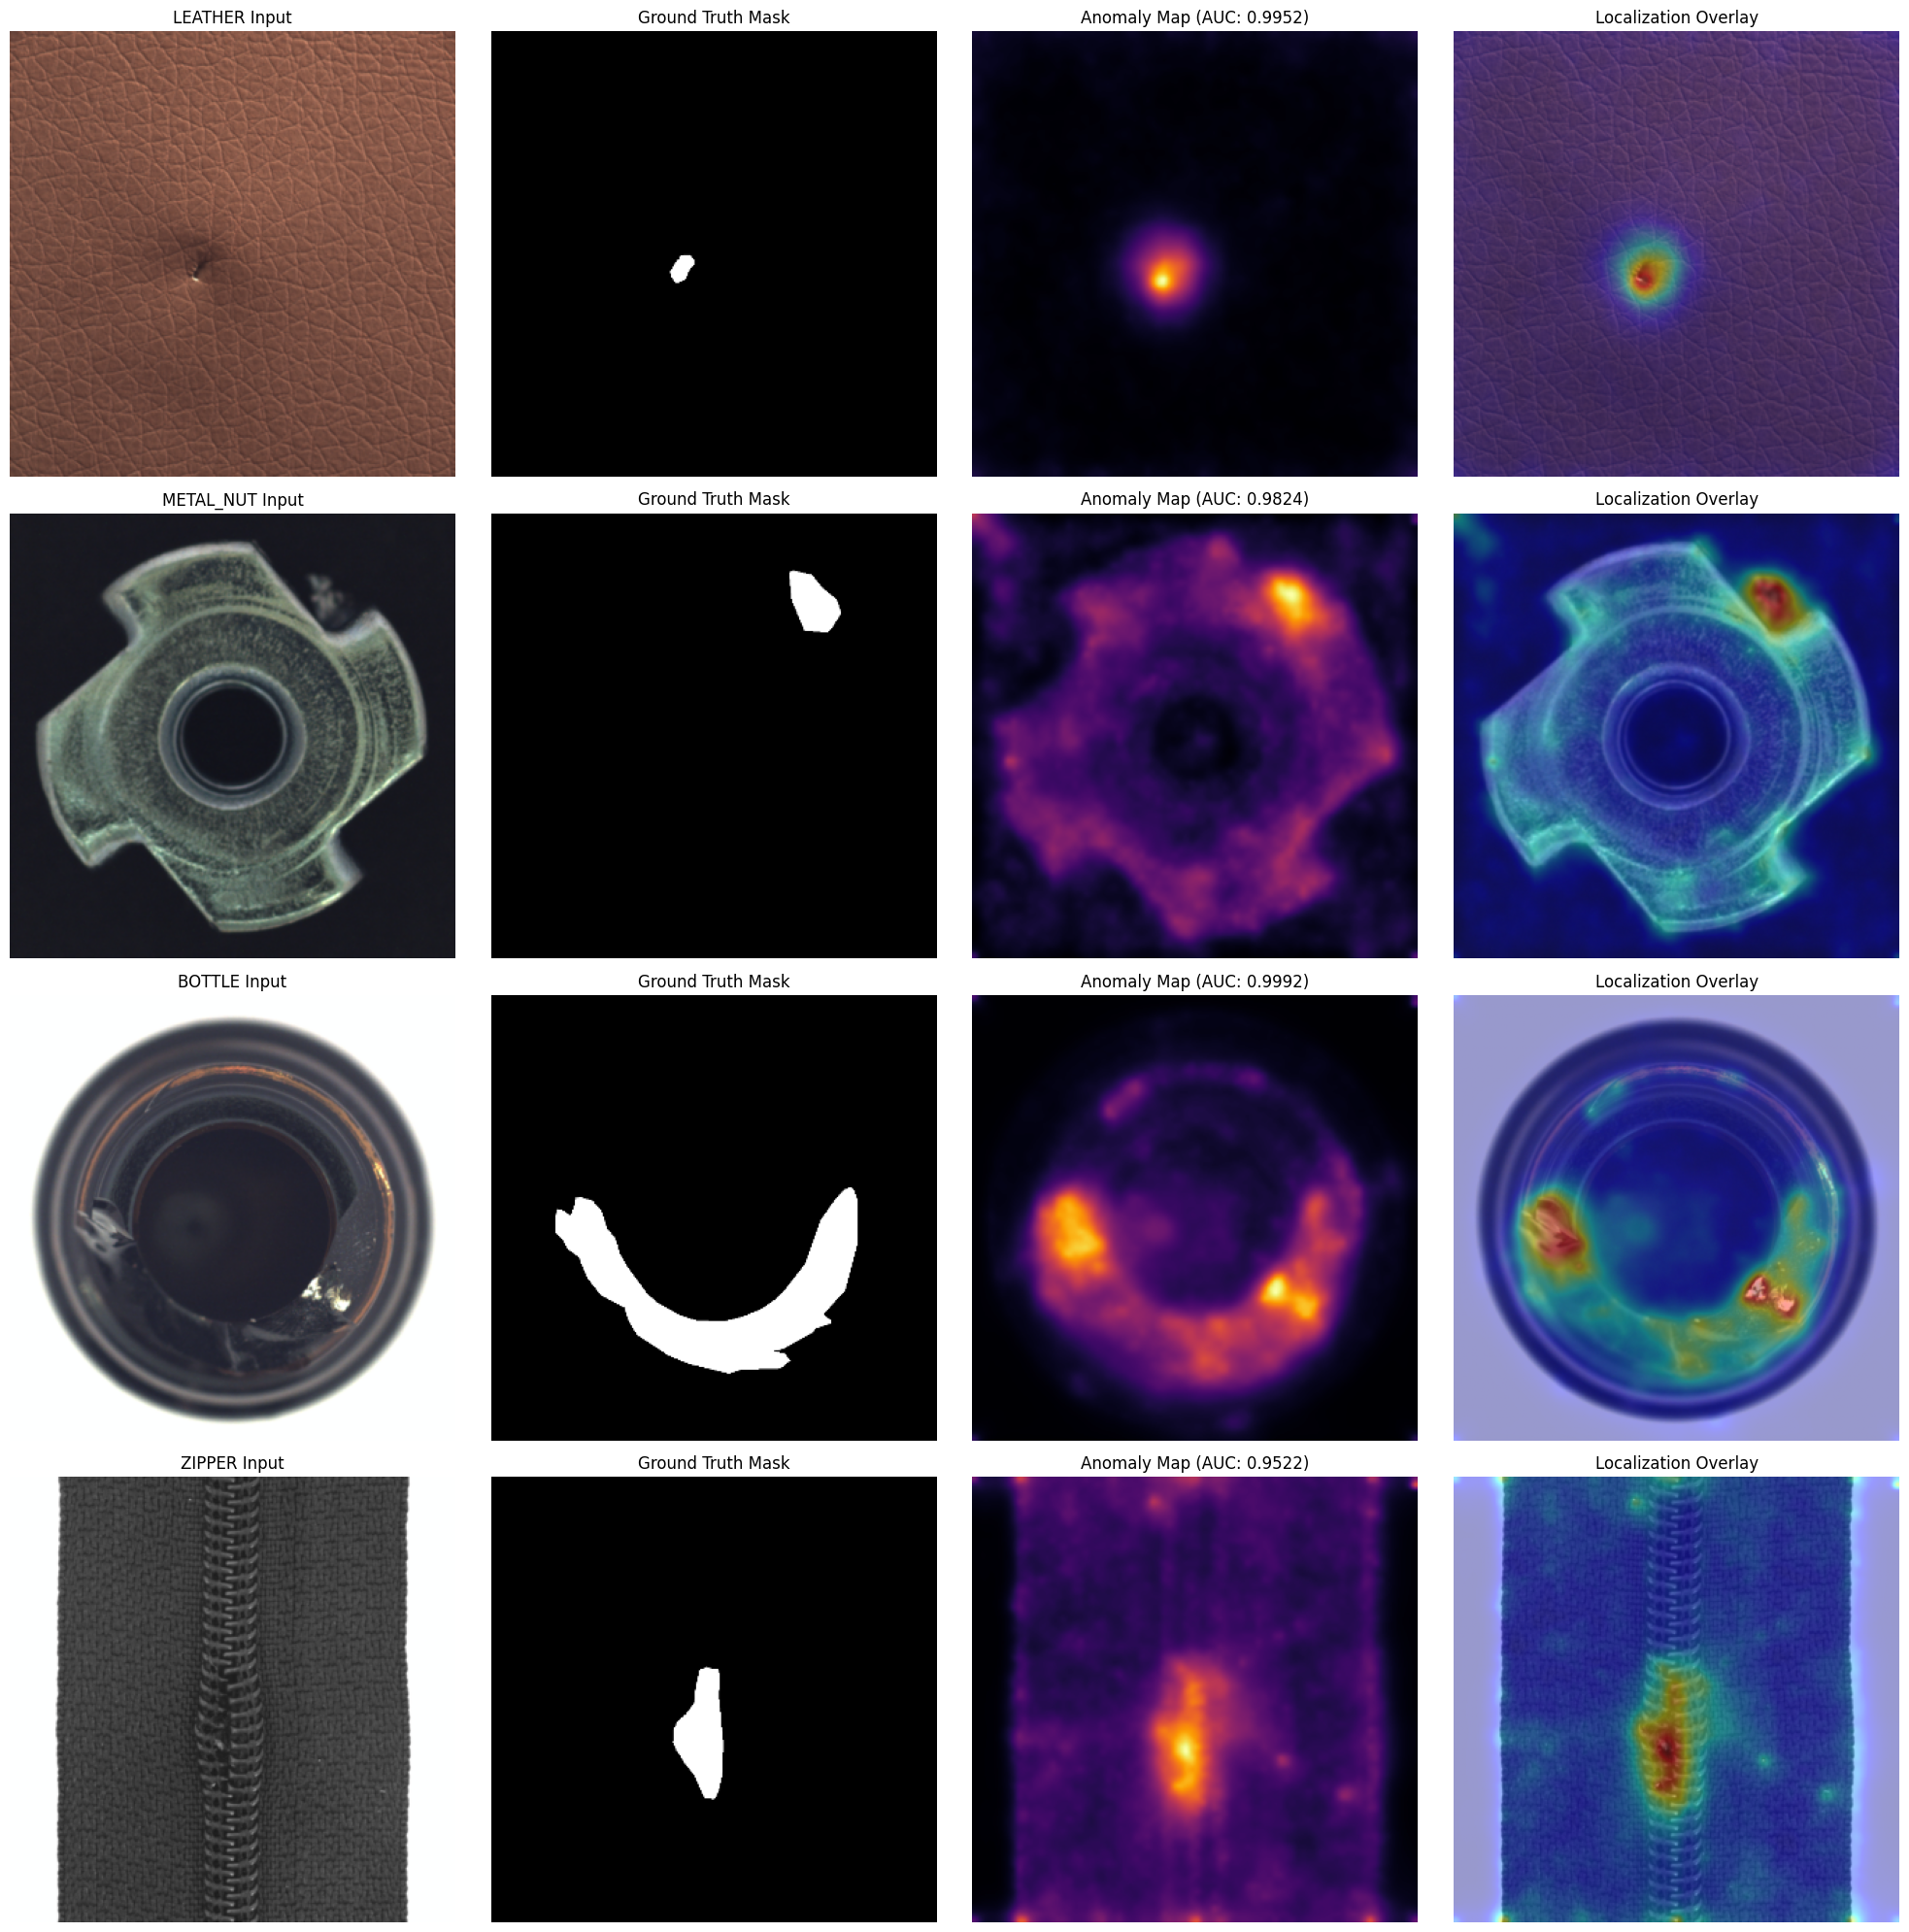

In [ ]:

def visualize_results():
    """
    Generates a visual dashboard comparing Input, Ground Truth, and Predicted Anomaly Map.
    Updated to support the 3-Layer Architecture (L1, L2, L3).
    """
    print("Generating visualization dashboard...")
    fig, axes = plt.subplots(len(TARGET_CATEGORIES), 4, figsize=(20, 5 * len(TARGET_CATEGORIES)))
    
    # Load a generic teacher for inference
    base_teacher = FeatureExtractor('wide_resnet50_2').to(device).eval()
    
    for i, category in enumerate(TARGET_CATEGORIES):
        ds = MVTecDataset(category, split='test')
        
        # Select a defective sample for demonstration
        defect_indices = [idx for idx, path in enumerate(ds.images) if 'good' not in path]
        idx = random.choice(defect_indices) if defect_indices else 0
        
        img_t, mask_t, _ = ds[idx]
        img_gpu = img_t.unsqueeze(0).to(device)
        
        # Load the trained model checkpoint
        checkpoint = torch.load(f"efficientad_{category}.pth", map_location=device, weights_only=False)
        
        student = FeatureExtractor('resnet18').to(device).eval()
        student.load_state_dict(checkpoint['student'])
        
        # INITIALIZE 3 ADAPTERS 
        ad1 = Adapter(64, 256).to(device).eval()
        ad1.load_state_dict(checkpoint['adapter1'])
        
        ad2 = Adapter(128, 512).to(device).eval()
        ad2.load_state_dict(checkpoint['adapter2'])
        
        ad3 = Adapter(256, 1024).to(device).eval()
        ad3.load_state_dict(checkpoint['adapter3'])
        
        # Perform Inference
        with torch.no_grad():
            t_out = base_teacher(img_gpu)
            s_out = student(img_gpu)
            
            # Adapt 3 Layers
            s1 = ad1(s_out[0])
            s2 = ad2(s_out[1])
            s3 = ad3(s_out[2])
            
            # Calculate distance map for all 3 layers
            h, w = t_out[0].shape[-2:]
            
            # Layer 1 Diff
            diff_l1 = torch.sum((t_out[0] - s1)**2, 1, keepdim=True)
            
            # Layer 2 Diff (Upsample to L1 size)
            diff_l2 = torch.sum((t_out[1] - s2)**2, 1, keepdim=True)
            diff_l2 = F.interpolate(diff_l2, size=(h, w), mode='bilinear')
            
            # Layer 3 Diff (Upsample to L1 size)
            diff_l3 = torch.sum((t_out[2] - s3)**2, 1, keepdim=True)
            diff_l3 = F.interpolate(diff_l3, size=(h, w), mode='bilinear')
            
            # Combine all 3 scales
            combined_map = diff_l1 + diff_l2 + diff_l3
            
            amap = F.interpolate(combined_map, size=(320, 320), mode='bilinear')
            amap = amap.squeeze().cpu().numpy()
            amap = cv2.GaussianBlur(amap, (5, 5), 0)
            
        # Prepare for Plotting (Denormalize)
        img_np = img_t.permute(1, 2, 0).numpy()
        img_np = np.clip((img_np * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406], 0, 1)
        
        # Column 1: Original Input
        axes[i, 0].imshow(img_np)
        axes[i, 0].set_title(f"{category.upper()} Input")
        axes[i, 0].axis('off')
        
        # Column 2: Ground Truth Mask
        mask_disp = mask_t.squeeze().numpy() if mask_t is not None else np.zeros((320,320))
        axes[i, 1].imshow(mask_disp, cmap='gray')
        axes[i, 1].set_title("Ground Truth Mask")
        axes[i, 1].axis('off')
        
        # Column 3: Raw Anomaly Heatmap
        axes[i, 2].imshow(amap, cmap='inferno')
        axes[i, 2].set_title(f"Anomaly Map (AUC: {checkpoint['auc']:.4f})")
        axes[i, 2].axis('off')
        
        # Column 4: Localization Overlay
        amap_norm = (amap - amap.min()) / (amap.max() - amap.min() + 1e-8)
        heatmap_color = cv2.applyColorMap((amap_norm * 255).astype(np.uint8), cv2.COLORMAP_JET)
        heatmap_color = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB) / 255.0
        overlay = (0.6 * img_np) + (0.4 * heatmap_color)
        
        axes[i, 3].imshow(np.clip(overlay, 0, 1))
        axes[i, 3].set_title("Localization Overlay")
        axes[i, 3].axis('off')
        
    plt.tight_layout()
    plt.show()

visualize_results()

### Final Audit Functions

In [ ]:

def normalize_map(m):
    """
    Standardizes feature map statistics. 
    Crucial for 'Zipper' to suppress high-variance fabric texture noise.
    """
    return (m - m.mean()) / (m.std() + 1e-6)

def compute_metrics(y_true, y_pred):
    """Calculates standard classification metrics for the report."""
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    return acc, prec, rec, f1

def run_final_audit():
    """
    Performs the final 'Surgical Evaluation' of the model.
    Applies category-specific logic to maximize performance on both 
    texture (Leather) and structure (Zipper/Nut) classes.
    """
    print("\n" + "="*120)
    print(f"{'OBJECT CLASS':<15} | {'IMG AUROC':<10} | {'PIX AUROC':<10} | {'F1':<8} | {'ACC':<8} | {'PREC':<8} | {'REC':<8}")
    print("="*120)

    # Teacher is always frozen (The Oracle)
    base_teacher = FeatureExtractor('wide_resnet50_2').to(device).eval()

    avg_img_auc, avg_pix_auc, avg_f1 = [], [], []

    for category in TARGET_CATEGORIES:
        path = f"efficientad_{category}.pth"
        if not os.path.exists(path): continue
            
        # 1. Load Best Model State (from the 100-epoch run)
        ckpt = torch.load(path, map_location=device, weights_only=False)
        threshold = ckpt['threshold']

        student = FeatureExtractor('resnet18').to(device).eval()
        student.load_state_dict(ckpt['student'])

        # 2. Load 3-Scale Adapters (Micro, Meso, Macro)
        ad1 = Adapter(64, 256).to(device).eval()
        ad2 = Adapter(128, 512).to(device).eval()
        ad3 = Adapter(256, 1024).to(device).eval()

        ad1.load_state_dict(ckpt['adapter1'])
        ad2.load_state_dict(ckpt['adapter2'])
        ad3.load_state_dict(ckpt['adapter3'])

        ds = MVTecDataset(category, split='test')
        loader = DataLoader(ds, batch_size=1, shuffle=False)

        y_true_img, y_scores_img = [], []
        y_true_pix, y_scores_pix = [], []

        with torch.no_grad():
            for img, mask, label in loader:
                img = img.to(device)

                t_out = base_teacher(img)
                s_out = student(img)

                s1, s2, s3 = ad1(s_out[0]), ad2(s_out[1]), ad3(s_out[2])
                h, w = t_out[0].shape[-2:]

                # 3. Calculate Squared Difference at all 3 scales
                diff_l1 = torch.sum((t_out[0] - s1)**2, 1, keepdim=True)
                diff_l2 = F.interpolate(torch.sum((t_out[1] - s2)**2, 1, keepdim=True), (h, w))
                diff_l3 = F.interpolate(torch.sum((t_out[2] - s3)**2, 1, keepdim=True), (h, w))

                # SURGICAL FUSION STRATEGY 
                # Zipper: High contrast (fabric vs metal) requires normalization to suppress background texture.
                # Others: Bottle/Leather need raw energy to preserve faint defect signals.
                if category == 'zipper':
                    diff = normalize_map(diff_l1) + normalize_map(diff_l2) + normalize_map(diff_l3)
                else:
                    diff = diff_l1 + diff_l2 + diff_l3

                amap = F.interpolate(diff, size=(320,320), mode='bilinear').squeeze().cpu().numpy()

                # Adaptive Smoothing: Zipper needs more blur to merge the broken teeth signal
                if category == 'zipper':
                    amap = cv2.GaussianBlur(amap, (7,7), 1.5)
                else:
                    amap = cv2.GaussianBlur(amap, (5,5), 0)

                # ADAPTIVE SCORING LOGIC
                if category == 'metal_nut':
                    img_score = np.mean(np.sort(amap.flatten())[-100:])
                elif category == 'zipper':
                    img_score = np.percentile(amap, 99.5)
                else: 
                    img_score = np.max(amap)

                y_scores_img.append(img_score)
                y_true_img.append(label.item())

                if mask is not None:
                    y_true_pix.extend(mask.flatten().numpy().astype(int))
                    y_scores_pix.extend(amap.flatten())

        # 4. Metric Calculation
        img_auc = roc_auc_score(y_true_img, y_scores_img)
        try: pix_auc = roc_auc_score(y_true_pix, y_scores_pix)
        except: pix_auc = 0.0

        y_pred = (np.array(y_scores_img) > threshold).astype(int)
        acc, prec, rec, f1 = compute_metrics(y_true_img, y_pred)

        avg_img_auc.append(img_auc)
        avg_pix_auc.append(pix_auc)
        avg_f1.append(f1)

        print(f"{category.upper():<15} | {img_auc:<10.4f} | {pix_auc:<10.4f} | {f1:<8.4f} | {acc:<8.4f} | {prec:<8.4f} | {rec:<8.4f}")

    print("="*120)
    print(f"{'SYSTEM MEAN':<15} | {np.mean(avg_img_auc):<10.4f} | {np.mean(avg_pix_auc):<10.4f} | {np.mean(avg_f1):<8.4f}")
    print("="*120)

run_final_audit()


OBJECT CLASS    | IMG AUROC  | PIX AUROC  | F1       | ACC      | PREC     | REC     
LEATHER         | 0.9973     | 0.9933     | 0.9735   | 0.9597   | 0.9485   | 1.0000  
METAL_NUT       | 0.9848     | 0.9672     | 0.9588   | 0.9304   | 0.9208   | 1.0000  
BOTTLE          | 0.9952     | 0.9790     | 0.9618   | 0.9398   | 0.9265   | 1.0000  
ZIPPER          | 0.9672     | 0.9792     | 0.9700   | 0.9536   | 0.9912   | 0.9496  
SYSTEM MEAN     | 0.9861     | 0.9797     | 0.9660  
